In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import glob
import pickle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50V2 as ResNet
from keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, SpatialDropout2D, BatchNormalization, Input,Activation, Dense, Flatten ,MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model,save_model
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay

In [60]:
path  = "/kaggle/input/fer2013/"

In [61]:
image_filenames = glob.glob(os.path.join(path,'**/*.jpg'), recursive=True)

# create an info dataframe
df = pd.DataFrame({'filename': image_filenames})
df['partition'] = df['filename'].apply(lambda x: x.split(os.sep)[-3])
df['label'] = df['filename'].apply(lambda x: x.split(os.sep)[-2])

df

,filename,partition,label
0,/kaggle/input/fer2013/test/surprise/PublicTest...,test,surprise
1,/kaggle/input/fer2013/test/surprise/PrivateTes...,test,surprise
2,/kaggle/input/fer2013/test/surprise/PrivateTes...,test,surprise
3,/kaggle/input/fer2013/test/surprise/PublicTest...,test,surprise
4,/kaggle/input/fer2013/test/surprise/PrivateTes...,test,surprise
...,...,...,...
35882,/kaggle/input/fer2013/train/happy/Training_188...,train,happy
35883,/kaggle/input/fer2013/train/happy/Training_165...,train,happy
35884,/kaggle/input/fer2013/train/happy/Training_108...,train,happy
35885,/kaggle/input/fer2013/train/happy/Training_304...,train,happy


In [62]:
image_generator=ImageDataGenerator(rescale=1/255)


Training = image_generator.flow_from_directory('/kaggle/input/fer2013/train',target_size=(224, 224),  
    batch_size=64,class_mode='categorical' )


Test = image_generator.flow_from_directory('/kaggle/input/fer2013/test' ,target_size=(224, 224),  
    batch_size=64,class_mode='categorical' )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [75]:
base_model=tf.keras.applications.VGG19(input_shape=(224,224,3),include_top=False,weights='imagenet')

In [76]:
for layer in base_model.layers:
    layer.trainable = False

In [77]:
NUM_CLASSES = 7

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(NUM_CLASSES, activation="softmax"))

opt = Adam(lr = 0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

In [78]:
#Model Summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 dense_22 (Dense)            (None, 256)               6422784   
                                                                 
 dense_23 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 26448967 (100.89 MB)
Trainable params: 6424583 (24.51 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [79]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [81]:
train_step=Training.n//Training.batch_size
test_step=Test.n//Test.batch_size


num_epochs = 20

#checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience= 6,
                          verbose=1,
                          restore_best_weights=True
                          )

model_checkpoint = ModelCheckpoint('vgg_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")

callbacks_list = [early_stopping,reduce_learningrate,model_checkpoint]

history = model.fit_generator(Training,
                                      steps_per_epoch=train_step,
                                      epochs=num_epochs, 
                                      validation_data=Test,
                                      validation_steps=test_step,
                                      callbacks=callbacks_list) 

/tmp/ipykernel_34/3478626488.py:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(Training,


Epoch 1/20
448/448 [==============================] - ETA: 0s - loss: 1.3877 - accuracy: 0.4826
Epoch 1: val_accuracy improved from -inf to 0.49693, saving model to vgg_model.h5
448/448 [==============================] - 85s 189ms/step - loss: 1.3877 - accuracy: 0.4826 - val_loss: 1.3277 - val_accuracy: 0.4969 - lr: 0.0010
Epoch 2/20
448/448 [==============================] - ETA: 0s - loss: 1.1558 - accuracy: 0.5713
Epoch 2: val_accuracy improved from 0.49693 to 0.51646, saving model to vgg_model.h5
448/448 [==============================] - 84s 188ms/step - loss: 1.1558 - accuracy: 0.5713 - val_loss: 1.2939 - val_accuracy: 0.5165 - lr: 0.0010
Epoch 3/20
448/448 [==============================] - ETA: 0s - loss: 1.0066 - accuracy: 0.6285
Epoch 3: val_accuracy improved from 0.51646 to 0.54827, saving model to vgg_model.h5
448/448 [==============================] - 84s 188ms/step - loss: 1.0066 - accuracy: 0.6285 - val_loss: 1.2466 - val_accuracy: 0.5483 - lr: 0.0010
Epoch 4/20
448/448 

In [82]:
# Loading the best fit model 
from keras.models import load_model
model.save('vgg_model.h5')
model = load_model("vgg_model.h5")
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 dense_22 (Dense)            (None, 256)               6422784   
                                                                 
 dense_23 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 26448967 (100.89 MB)
Trainable params: 6424583 (24.51 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [83]:
score = model.evaluate(Test)
print(score)

113/113 [==============================] - 17s 147ms/step - loss: 20.6308 - accuracy: 0.5481
[20.63078498840332, 0.5480635166168213]


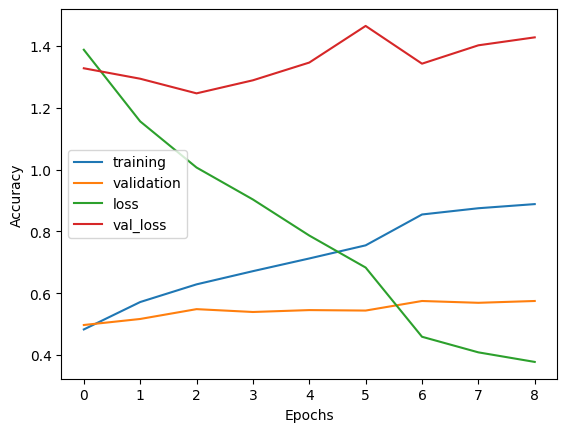

In [84]:
plt.plot(history.history['accuracy'],label='training')
plt.plot(history.history['val_accuracy'],label='validation')
plt.plot(history.history["loss"],label='loss')
plt.plot(history.history["val_loss"],label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

1/1 [==============================] - 0s 20ms/step


Text(0.5, 1.0, 'sad')

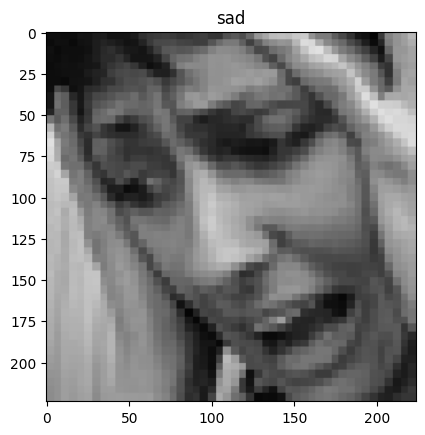

In [98]:
images,labels=Test.next()
pred=np.argmax(model.predict(tf.expand_dims(images[1],axis=0)))

ls = list(Test.class_indices.keys())

plt.imshow(images[1])
plt.title(ls[pred])

1/1 [==============================] - 0s 20ms/step


Text(0.5, 1.0, 'fear')

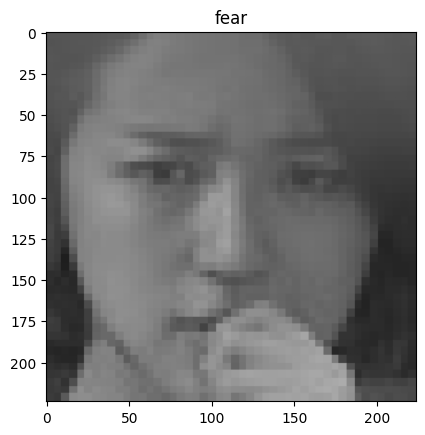

In [101]:
images,labels=Test.next()
pred=np.argmax(model.predict(tf.expand_dims(images[50],axis=0)))

ls = list(Test.class_indices.keys())

plt.imshow(images[50])
plt.title(ls[pred])